In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import utils


plt.ion()   # interactive mode

In [2]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

In [3]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks
from torchvision.ops import masks_to_boxes

In [4]:
from torchvision.io import read_image, decode_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import v2
from torchvision.io import read_image
import torch.utils.data
torch.manual_seed(0)

In [5]:
torch.cuda.is_available()

True

In [6]:
device=torch.device('cuda')
print(f"Using {device} device")

Using cuda device


In [7]:
cudnn.enabled = True

In [8]:
cudnn.benchmark = False
cudnn.deterministic = True

In [9]:
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights

In [10]:
weights = LRASPP_MobileNet_V3_Large_Weights.DEFAULT
class_names=['__background__','F-15 Eagle',
 'F-22 Raptor',
 'a-10 thunderbolt ii',
 'ac-130 ghostrider',
 'b-1 lancer',
 'b-2 spirit',
 'b-52 stratofortress',
 'f-35 lightning ii']
sem_classes = [
    '__background__', 'a-10', 'ac-130', 'b-1', 'b-2', 'b-52', 'f-15', 'f-22','f-35']
weights.meta["categories"]=class_names

In [11]:
weights

LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1

In [12]:
transforms=v2.Compose([#v2_extras.CocoDetectionToVOCSegmentation(),
                       #v2.RandomResizedCrop((520), antialias=True),
                       v2.Resize(520),v2.PILToTensor(),
                       #v2.PILToTensor(),
                       v2.ToDtype(torch.float32, scale=True),
                       v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], inplace=True)])
#transforms = weights.transforms()

In [13]:
# Model class must be defined somewhere
model = torch.load('models/lraspp_custom.pt')#.cpu()
checkpoint = torch.load('models/c_lraspp_custom.pt', weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

C:\Users\arinz\AppData\Local\Temp\ipykernel_16888\1312198090.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/lraspp_custom.pt')#.cpu()


<All keys matched successfully>

In [14]:
model = model.to(device)

In [15]:
img_ = decode_image("data/test_imgs/b52.jpg")

In [16]:
transforms

Compose(
      Resize(size=[520], interpolation=InterpolationMode.BILINEAR, antialias=True)
      PILToTensor()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=True)
)

In [17]:
input_data = transforms(img_)

In [18]:
input_data

tensor([[[-1.0904, -1.0904, -1.0904,  ...,  0.3481,  0.3823,  0.4166],
         [-1.0904, -1.0904, -1.0904,  ...,  0.4337,  0.4679,  0.4679],
         [-1.0733, -1.0733, -1.0733,  ...,  0.4851,  0.5022,  0.5022],
         ...,
         [ 0.5193,  0.4851,  0.4851,  ...,  1.3755,  1.3413,  1.2728],
         [ 0.5536,  0.5364,  0.5193,  ...,  1.4098,  1.3755,  1.3070],
         [ 0.5536,  0.5707,  0.5707,  ...,  1.3755,  1.3927,  1.3242]],

        [[-0.0049, -0.0049, -0.0049,  ...,  1.0630,  1.0805,  1.0980],
         [-0.0049, -0.0049, -0.0049,  ...,  1.1506,  1.1506,  1.1506],
         [ 0.0126,  0.0126,  0.0126,  ...,  1.2031,  1.1856,  1.1856],
         ...,
         [ 0.9405,  0.9055,  0.9055,  ...,  1.5182,  1.4832,  1.4132],
         [ 0.9755,  0.9755,  0.9580,  ...,  1.5532,  1.5182,  1.4482],
         [ 0.9930,  1.0105,  1.0105,  ...,  1.5182,  1.5357,  1.4657]],

        [[ 1.5071,  1.5071,  1.5071,  ...,  2.0648,  2.0648,  2.0823],
         [ 1.5071,  1.5071,  1.5071,  ...,  2

In [19]:
input_data = np.expand_dims(input_data, axis=0)

In [20]:
input_data

array([[[[-1.0904187 , -1.0904187 , -1.0904187 , ...,  0.34806067,
           0.38231018,  0.41655967],
         [-1.0904187 , -1.0904187 , -1.0904187 , ...,  0.43368444,
           0.46793392,  0.46793392],
         [-1.0732939 , -1.0732939 , -1.0732939 , ...,  0.4850587 ,
           0.50218344,  0.50218344],
         ...,
         [ 0.5193082 ,  0.4850587 ,  0.4850587 , ...,  1.3755461 ,
           1.3412966 ,  1.2727976 ],
         [ 0.5535577 ,  0.5364329 ,  0.5193082 , ...,  1.4097956 ,
           1.3755461 ,  1.3070471 ],
         [ 0.5535577 ,  0.57068247,  0.57068247, ...,  1.3755461 ,
           1.3926709 ,  1.3241718 ]],

        [[-0.00490182, -0.00490182, -0.00490182, ...,  1.0630252 ,
           1.0805323 ,  1.0980393 ],
         [-0.00490182, -0.00490182, -0.00490182, ...,  1.1505603 ,
           1.1505603 ,  1.1505603 ],
         [ 0.01260518,  0.01260518,  0.01260518, ...,  1.2030813 ,
           1.1855743 ,  1.1855743 ],
         ...,
         [ 0.94047624,  0.90546227

In [21]:
model.eval()

LRASPP(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1

In [22]:
with torch.no_grad():
    result_torch = model(torch.as_tensor(input_data).float().to(device))['out']

In [23]:
result_torch

tensor([[[[ 9.3159,  9.3159,  9.3159,  ..., 10.7649, 10.7649, 10.7649],
          [ 9.3159,  9.3159,  9.3159,  ..., 10.7649, 10.7649, 10.7649],
          [ 9.3159,  9.3159,  9.3159,  ..., 10.7649, 10.7649, 10.7649],
          ...,
          [11.1252, 11.1252, 11.1252,  ..., 10.8613, 10.8613, 10.8613],
          [11.1252, 11.1252, 11.1252,  ..., 10.8613, 10.8613, 10.8613],
          [11.1252, 11.1252, 11.1252,  ..., 10.8613, 10.8613, 10.8613]],

         [[-1.2818, -1.2818, -1.2818,  ..., -1.3886, -1.3886, -1.3886],
          [-1.2818, -1.2818, -1.2818,  ..., -1.3886, -1.3886, -1.3886],
          [-1.2818, -1.2818, -1.2818,  ..., -1.3886, -1.3886, -1.3886],
          ...,
          [-1.5250, -1.5250, -1.5250,  ..., -1.3100, -1.3100, -1.3100],
          [-1.5250, -1.5250, -1.5250,  ..., -1.3100, -1.3100, -1.3100],
          [-1.5250, -1.5250, -1.5250,  ..., -1.3100, -1.3100, -1.3100]],

         [[ 0.2364,  0.2364,  0.2364,  ..., -0.2093, -0.2093, -0.2093],
          [ 0.2364,  0.2364,  

In [24]:
normalized_mask = torch.nn.functional.softmax(result_torch, dim=1)


In [25]:
result_torch.shape

torch.Size([1, 21, 520, 520])

In [26]:
normalized_mask

tensor([[[[9.9908e-01, 9.9908e-01, 9.9908e-01,  ..., 9.9971e-01,
           9.9971e-01, 9.9971e-01],
          [9.9908e-01, 9.9908e-01, 9.9908e-01,  ..., 9.9971e-01,
           9.9971e-01, 9.9971e-01],
          [9.9908e-01, 9.9908e-01, 9.9908e-01,  ..., 9.9971e-01,
           9.9971e-01, 9.9971e-01],
          ...,
          [9.9983e-01, 9.9983e-01, 9.9983e-01,  ..., 9.9975e-01,
           9.9975e-01, 9.9975e-01],
          [9.9983e-01, 9.9983e-01, 9.9983e-01,  ..., 9.9975e-01,
           9.9975e-01, 9.9975e-01],
          [9.9983e-01, 9.9983e-01, 9.9983e-01,  ..., 9.9975e-01,
           9.9975e-01, 9.9975e-01]],

         [[2.4949e-05, 2.4949e-05, 2.4949e-05,  ..., 5.2684e-06,
           5.2684e-06, 5.2684e-06],
          [2.4949e-05, 2.4949e-05, 2.4949e-05,  ..., 5.2684e-06,
           5.2684e-06, 5.2684e-06],
          [2.4949e-05, 2.4949e-05, 2.4949e-05,  ..., 5.2684e-06,
           5.2684e-06, 5.2684e-06],
          ...,
          [3.2064e-06, 3.2064e-06, 3.2064e-06,  ..., 5.1757

In [27]:
for x , y in enumerate(weights.meta["categories"]):
    print(x,y)
    #break

0 __background__
1 F-15 Eagle
2 F-22 Raptor
3 a-10 thunderbolt ii
4 ac-130 ghostrider
5 b-1 lancer
6 b-2 spirit
7 b-52 stratofortress
8 f-35 lightning ii


In [28]:
sem_class_to_idx = {clss: idx for (idx, clss) in enumerate(class_names)}

In [37]:
f15_mask = normalized_mask[0, sem_class_to_idx['ac-130 ghostrider']]

In [38]:
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

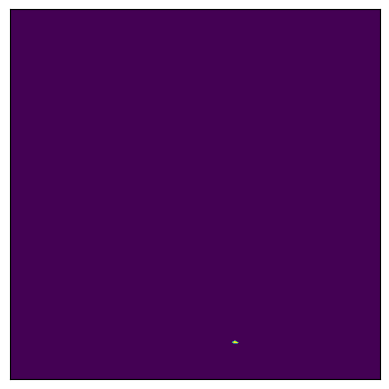

In [39]:
show(f15_mask)

In [32]:
class_dim = 1
boolean_f15_mask = (normalized_mask.argmax(class_dim) == sem_class_to_idx['b-52 stratofortress'])

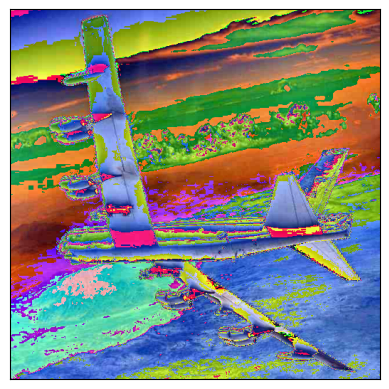

In [33]:
show(draw_segmentation_masks(transforms(img_), masks=boolean_f15_mask, alpha=1))